# Simulated Data

In [3]:
# Imports
#%matplotlib notebook 
%matplotlib inline 
import numpy as np
from commpy import PSKModem, QAMModem
from commpy.filters import rectfilter, gaussianfilter, rrcosfilter, rcosfilter
from matplotlib import pyplot as plt
from matplotlib import pyplot  
from scipy.signal import find_peaks
import pandas as pd
import scipy.stats as st
from scipy import signal
import seaborn as sns
from sklearn import mixture


In [20]:
# Set plot theme
sns.set(font_scale=0.7)

## Helper functions
def get_iq(df_s):
    """
    transform a df series of complex vals
    into the dataFrame of real and imaginary columns.
    Return: pandas.DataFrame
    """    
    dfc = {
        "i": (df_s.values).real,
        "q": (df_s.values).imag
    }
    
    return pd.DataFrame(dfc)

def detect_freq_range(z, alpha=0.95):
    """
    View lagged correlation of signal to determine
    a frequency responce and filter out the decaying harmonics...
    Input: z_t complex time signal.
    
    """    
    auto_cor = signal.correlate(z,
                       z,
                       mode="same")/len(z)
    
    lags = signal.correlation_lags(z.size, z.size, mode="same")
    
    a_cor = auto_cor[lags]

    asym_scf = np.fft.fftshift(np.fft.fft(auto_cor))
    
    
    y = np.log(np.abs(asym_scf))
    peaks_caf =  find_peaks(y)[0]
    
    #create alpha% confidence interval for population mean weight
    lb, ub = st.t.interval(alpha=alpha,
                  df=len(peaks_caf)-1,
                  loc=np.mean(peaks_caf),
                  scale=st.sem(peaks_caf)) 
    p_indexs = np.r_[int(np.floor(lb)):int(np.ceil(ub))]
    p_tones = np.zeros(asym_scf.size, dtype=np.complex64)
    
    p_tones[p_indexs] = np.fft.ifft(np.fft.fft(auto_cor)[p_indexs])
    
    
    return lb, ub, p_indexs, p_tones


def pplot(df_s, df):
    """
    df_s is a dataframe series containing complex values for a scatter plot
    df is the full data frame so I can access the noise levels for coloring
    """
    df_iq = get_iq(df_s)
    color_ = 1 - np.abs(df["noise_vec"])/np.max(np.abs(df["noise_vec"]))
    df_iq["complement_noise_lvl"] = color_
    plt.close("all")
    df_iq.plot.scatter(x="i", y="q",c="complement_noise_lvl", colormap='viridis', alpha=color_ )
    plt.title(df_s.name)
    plt.show()

In [23]:
#
# Set up the paramaters
##
nsymbols=16
repeats_per_symbol = 16 # less than 16
samples_per_second = 1e2*32
message_len = 200
total_samples = repeats_per_symbol*message_len
baseband_carrier_freq = 1  # fc center frequency 
noise_sd = 0.4 # noise 


nbits = np.ceil(np.log2(nsymbols))
sym_per_sec = samples_per_second/repeats_per_symbol

 


# calculate
duration = total_samples/samples_per_second
time = np.linspace(0, duration, total_samples)  # clock time of each sample

dt = duration/(total_samples)

freqs = np.fft.ifftshift(np.fft.fftfreq(len(time), dt))


bit_rate = nbits*sym_per_sec

ALPHA = sym_per_sec/2
print(f"Theoritical alphas will be a roll of {ALPHA} \n nbits{nbits} \n sym_per_sec  {sym_per_sec  }")




## apply pulse shaping filter

### ---------------------- Hamming Filter  -----------------------------------

# h_filter = np.hamming(repeats_per_symbol)  # no idea if this is the right thing to convolve!
# h_filter  = h_filter/np.sum(h_filter)

### ---------------------- Rectangular pulse -----------------------------------

N   =   repeats_per_symbol             #(int) – Length of the filter in samples.
Ts  =   sym_per_sec       #(float) – Symbol period in seconds.
Fs  =   1/dt             #(float) – Sampling Rate in Hz.
print(N, Ts, Fs)

time_index, h_filter = rectfilter(N, Ts, Fs)




print(f" Set Fs: {1/dt} \n Set dt: {dt} \n Total_Samples: {len(time)}")

params = {
    'nsymbols':nsymbols,
    'repeats_per_symbol'   :  repeats_per_symbol,
    'samples_per_second'  :   samples_per_second,
    'message_len'   :   message_len ,
    'total_samples'  :  total_samples ,
    'baseband_carrier_freq' :   baseband_carrier_freq,
    'noise_sd'  :   noise_sd ,
    'duration' :  duration, 
    'time'  :   time, 
    'dt'  :   dt,
    'freqs'  :   freqs,
    "h_filter": h_filter
    }

Theoritical alphas will be a roll of 100.0 
 nbits4.0 
 sym_per_sec  200.0
16 200.0 3200.0
 Set Fs: 3200.0 
 Set dt: 0.0003125 
 Total_Samples: 3200


In [25]:
# Definition to get test data
def gen_df(params={}):
    print("generating df... ")
    # set params
    nsymbols =  params["nsymbols"]
    repeats_per_symbol = params["repeats_per_symbol"]
    samples_per_second = params["samples_per_second"]
    message_len = params["message_len"]
    total_samples = params["total_samples"]
    baseband_carrier_freq = params["baseband_carrier_freq"]
    noise_sd = params["noise_sd"]
    duration = params["duration"]
    time =  params["time"]
    dt = params["dt"]
    freqs = params["freqs"]
    h_filter = params["h_filter"]
    
    # define values...     
    baseband_signal =  np.exp(1j*2*np.pi*time*baseband_carrier_freq)
    baseband_inv = np.exp(-1j*2*np.pi*time*baseband_carrier_freq)
    
    # define constellation
    #### ___________________________________________________############
    m = QAMModem(nsymbols)
    ## m = PSKModem(nsymbols) # Want to test BPSK
    
    
    con = m.constellation
    con = con/np.max(np.abs(con))  # power normablizing
    
    # set message
    symbol_message = np.random.randint(0, nsymbols, message_len)
    message_with_repeats = np.repeat(symbol_message, repeats_per_symbol)
    
    # Pulse shapeing with hamming filter
    # better repeat scheme
    #
    pad_message = np.zeros(len(symbol_message)*repeats_per_symbol, dtype=complex)
    indexes = np.arange(len(symbol_message))*repeats_per_symbol
    pad_message[indexes] = con[symbol_message]
    

    # print(np.sum(hamming_filter))
    
    # Note I didnt use the pad message here instead I convolved the iq_encoded message  I was curious what the difference in the spectrogram would be
    smooth_iq_encoded_message = signal.fftconvolve(pad_message, h_filter, mode="same")
    
    # An IQ encoding of a message is just a symbol lookup table
    iq_encoded_message = con[message_with_repeats]
    
    # Modulate the encoding unto the baseband cf
    modulated = iq_encoded_message*baseband_signal
    smooth_modulated = smooth_iq_encoded_message*baseband_signal
    
    # AWGN 
    noise = np.random.normal(0,noise_sd/np.sqrt(2), len(iq_encoded_message)) + \
        1.j*np.random.normal(0,noise_sd/np.sqrt(2), len(iq_encoded_message))
    
    
    # Channel refers to the idea of a channel model with experimental effects.  Here AWGN.
    channel_iq = modulated + noise
    smooth_channel_iq = smooth_modulated + noise
    
    # Unmodulate with baseband inv to get the original modulation with noise effects
    unmodulated = channel_iq*baseband_inv
    smooth_unmodulated = smooth_channel_iq*baseband_inv
    
    data = {
        "modulated": modulated,
        "unmodulated":unmodulated,
        "channel_iq": channel_iq,
        "iq_encoded_message": iq_encoded_message,
        "baseband_signal": baseband_signal,
        "baseband_inv": baseband_inv,
        "noise_vec":noise,
        "smooth_channel_iq": smooth_channel_iq,
        "smooth_modulated": smooth_modulated,
        "smooth_iq_encoded_message": smooth_iq_encoded_message,
        "smooth_unmodulated": smooth_unmodulated
        }
    
    df = pd.DataFrame(data)
    return params, df
    
    
params, df = gen_df(params=params)  

print("columns", [col for col in df.columns.values])
# optional prints... 

# print(df.describe())
# print(df.info())

generating df... 
columns ['modulated', 'unmodulated', 'channel_iq', 'iq_encoded_message', 'baseband_signal', 'baseband_inv', 'noise_vec', 'smooth_channel_iq', 'smooth_modulated', 'smooth_iq_encoded_message', 'smooth_unmodulated']


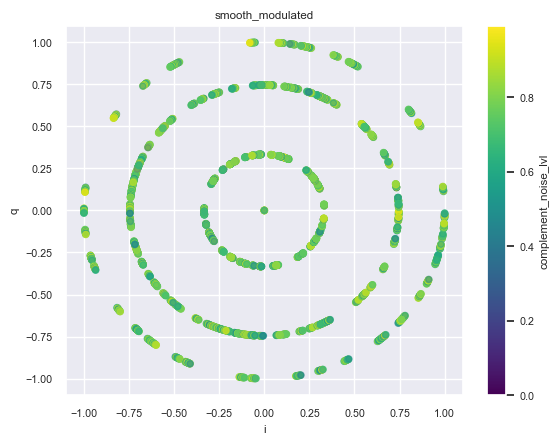

In [26]:
# defint input data... and plot iq 

# select = 'channel_iq'
# select = "unmodulated"
# select = 'smooth_channel_iq'
# select = 'smooth_unmodulated'
select = 'smooth_modulated'


x = np.asarray(df[select])  

pplot(df[select], df)


[-2.35702260e-01-2.35702260e-01j -2.35238861e-01-2.36164750e-01j
 -2.34774554e-01-2.36626329e-01j ...  5.52363114e-19+1.40613433e-16j
  4.14273134e-19+2.10921370e-16j  1.05460888e-16+1.05460888e-16j] (3200,)


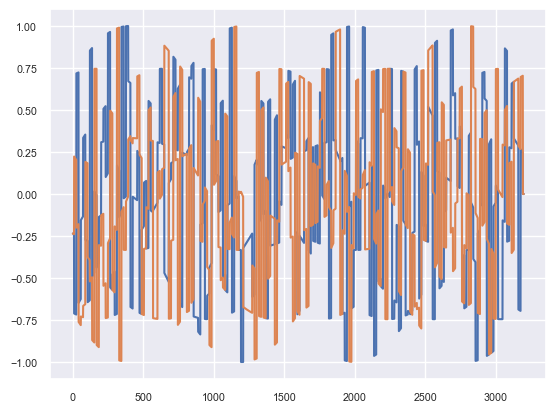

[-0.5       -0.4996875 -0.499375  ...  0.4990625  0.499375   0.4996875]


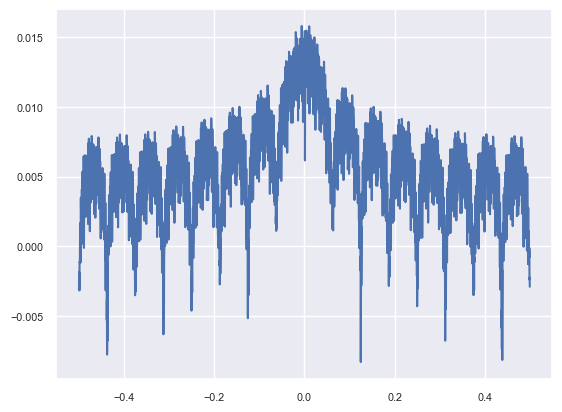

[-0.13168193-0.29606174j -0.23568198-0.23572946j -0.37540498-0.34091718j
 ...  0.37158908-0.18610083j -0.31756833-0.30428162j
 -0.33238904-0.08524453j]


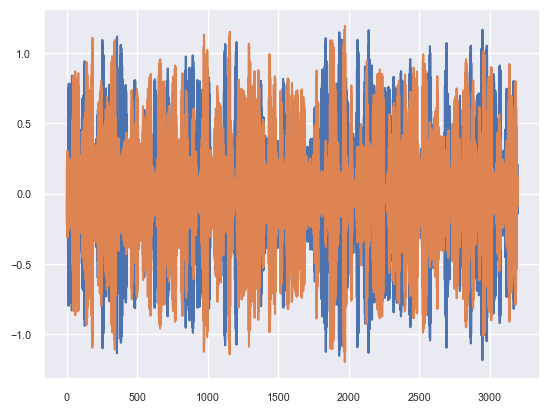

In [27]:
print(x, x.shape)
plt.close("all")
plt.plot(np.real(x))
plt.plot(np.imag(x))
plt.show()

x_f = np.fft.fft(x) # fourier transform of x(t) 
x_f = np.fft.fftshift(x_f)

psd = 20*np.log10(np.abs(x_f))/len(x_f)


n = x_f.size
timestep = 1
freq = np.fft.fftshift(np.fft.fftfreq(n, d=timestep))
print(freq)


plt.close("all")
plt.plot(freq, psd)
plt.show()
print(x_f)


y_f = np.where(psd < 0.01, 0, x_f)
y = np.fft.ifft(y_f)

plt.close("all")
plt.plot(np.real(y))
plt.plot(np.imag(y))
plt.show()




# Estimate a low bias PSD via frequency smoothing method (FSM)
following Chad Spooner's blog post to write a biased estimator of the PSD.

https://cyclostationary.blog/2015/11/20/csp-estimators-the-frequency-smoothing-method/

Estimate the following feature values.
1. The Periodogram (p_0)
2. The Cyclic Periodogram (cp_0)
3. The Conjugate Cyclic Periodogram (c_cp_0)
4. The Frequency Smoothed Periodogram (fsp) ... is approximately equal to the PSD.
5. The Frequency Smoothed Cyclic Periodogram (fscp) ... is approximately equal to the SCF. 
6. The Frequency Smoothed Conjugate Cyclic Periodogram (c_fscp) ... is approximately equal to the C_SCF. 


freq of max peak estimate: -19.0


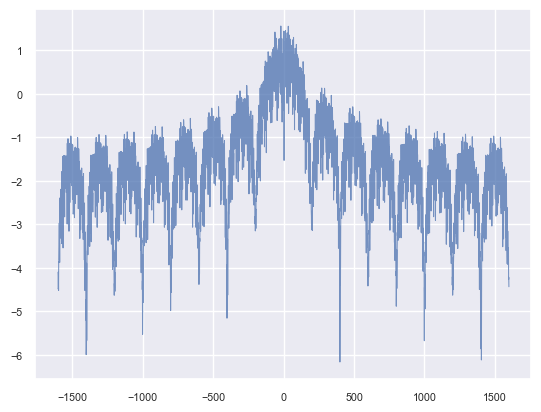

'\n'

In [28]:
# 1. The Periodogram (p_0)
def p_0(z_t):
    """
    input is a complex valued discrete time signal
    output is The periodogram
    """
    N = len(z_t)
    Z_f = np.fft.fftshift(np.fft.fft(z_t))
    ab_s =  np.abs(Z_f)
    I_f = ab_s*ab_s/N
    return I_f

I_f = p_0(x)

print(f"freq of max peak estimate: {freqs[np.argmax(I_f)]}")


# Graph
plt.close("all")
plt.plot(freqs, np.log10(I_f), linewidth=0.75, alpha=0.75)
plt.show()

'''
'''




[0.00000000e+00 3.12597687e-04 6.25195374e-04 ... 9.99374805e-01
 9.99687402e-01 1.00000000e+00]
carrier_freq estimate: -19.0


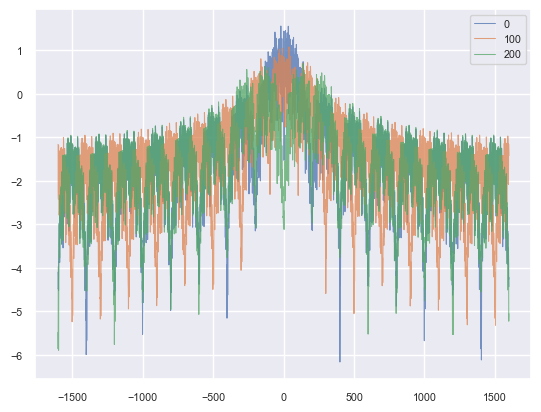

In [29]:
#2. The Cyclic Periodogram (cp_0)
def cp_0(z_t, alpha_vec, freqs):
    """
    return df columns are alphas and rows are freqs
    """
    
    fft = lambda x: np.fft.fftshift(np.fft.fft(x))
    
    N = len(z_t) 
    Z_f = fft(z_t)
    data = {}
    for r in alpha_vec:
        left_rolled_f = np.roll(Z_f, r)
        right_rolled_f = np.roll(Z_f, -r)
        f_rolled = right_rolled_f*np.conj(left_rolled_f)/N
        p_rolled = np.abs(f_rolled)
        data[r] = p_rolled
    df = pd.DataFrame(data) 
    df.index = freqs
    return df , alpha_vec


print(time)
alpha_vec = np.asarray([0, 1, 2])*int(ALPHA) 

df_CI_f, alpha_vec = cp_0(x, alpha_vec, freqs)


print(f"carrier_freq estimate: {freqs[np.argmax(df_CI_f[0])]}")
'''
pyplot.close("all")
pyplot.specgram(modulated ,Fs=1)
pyplot.xlabel("Time")
pyplot.ylabel("Frequency")
pyplot.show()
'''

# Graph
plt.close("all")
(np.log10(np.abs(df_CI_f))).plot(linewidth=0.75, alpha=0.75)
plt.show()





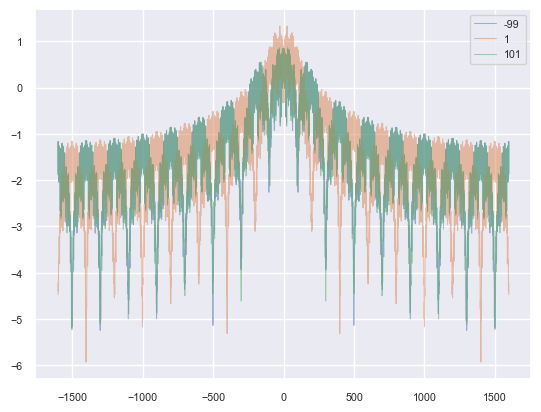

'\n'

In [30]:
#3. The Conjugate Cyclic Periodogram (c_cp_0)
def c_cp_0(z_t, alpha_vec, freqs):
    """
    return df columns are alphas and rows are freqs
    """
    fft = lambda x: np.fft.fftshift(np.fft.fft(x))
    
    N = len(z_t) 
    Z_f = fft(z_t)
    data = {}
    for r in alpha_vec:
        #left_rolled_f = np.roll(Z_f, r)       
        # conjugate method double conjugates in the correlation 
        # def so one can simply flip the right rolled axis and multiply directly 
        right_rolled_f = np.roll(Z_f, -r)
        f_rolled = right_rolled_f*np.flipud(right_rolled_f)/N  
        p_rolled = np.abs(f_rolled)
        data[r] = p_rolled
        
    df = pd.DataFrame(data) 
    df.index = freqs
    return df , alpha_vec




alpha_vec =  1 + np.asarray([-1, 0, 1])*int(ALPHA) 
df_CI_f, alpha_vec = c_cp_0(x, alpha_vec, freqs)


# Graph
plt.close("all")
(np.log10(np.abs(df_CI_f))).plot(linewidth=0.75, alpha=0.5)
plt.show()
'''
'''

SCF estimate max peak: 19.0


<IPython.core.display.Javascript object>


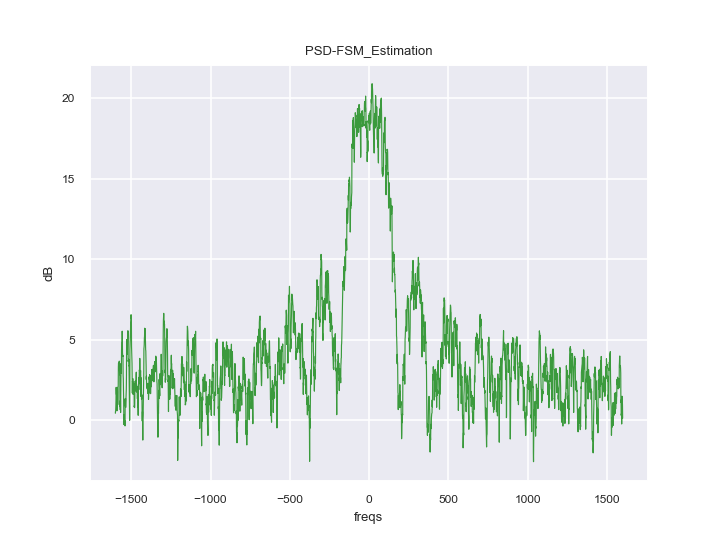

'\n'

In [59]:
# 4. The Frequency Smoothed Periodogram (fsp)
def fsp(z_t, N, Ts, Fs):
    """
    z_t is a complex valued discrete time signal.
    N (int) – Length of the filter in samples.
    Ts (float) – Symbol period in seconds.
    Fs (float) – Sampling Rate in Hz.
    """
    time_index, h_rect = rectfilter(N, Ts, Fs)
    I_f = p_0(z_t)
    return signal.fftconvolve(I_f, h_rect, "same")
    
N   =   10  #repeats_per_symbol             #(int) – Length of the filter in samples.
Ts  =   20    #sym_per_sec       #(float) – Symbol period in seconds.
Fs  =   10      # 1/dt             #(float) – Sampling Rate in Hz.

fs_I_f = fsp(x, N, Ts, Fs)


print(f"SCF estimate max peak: {freqs[np.argmax(fs_I_f)]}")
# Graph
plt.close("all")
plt.plot(freqs, 10*np.log10(fs_I_f), linewidth=0.75, alpha=0.75, color="green")
plt.title("PSD-FSM_Estimation")
plt.xlabel("freqs")
plt.ylabel("dB")
plt.show()
'''
'''

3200


<IPython.core.display.Javascript object>


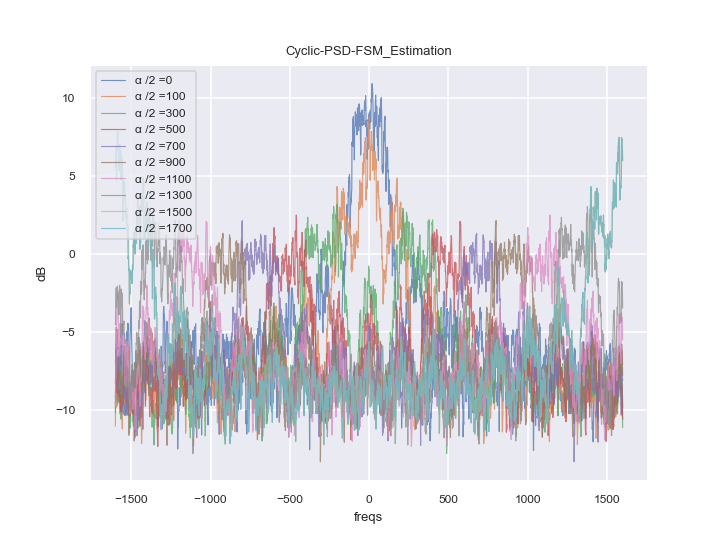

'\n'

In [64]:
# 5. The Frequency Smoothed Cyclic Periodogram (fscp)
def fscp(z_t, alpha_vec, N, Ts, Fs, freqs):
    f = lambda x, h=None: signal.fftconvolve(x, h, "same")
    time_index, h_rect = rectfilter(N, Ts, Fs)
    h_rect = h_rect/np.sum(h_rect)
    df_cp, alpha_vec = cp_0(z_t, alpha_vec, freqs)
    fcp = df_cp.transform(f, axis=0, h=h_rect)
    return fcp, alpha_vec



N   =   10       #(int) – Length of the filter in samples.
Ts  =   20       #(float) – Symbol period in seconds.
Fs  =   10       #(float) – Sampling Rate in Hz.

alpha_vec = np.linspace(0, 1700//ALPHA, 10).astype(int)*int(ALPHA) 

print(len(x))


df_fs_CI_f, alpha_vec = fscp(x, alpha_vec, N, Ts, Fs, freqs)

cols = df_fs_CI_f.columns
ccols = [f"{chr(945)} /2 ={i}" for i in cols]
df_fs_CI_f.columns = ccols

# Graph
plt.close("all")
(10*np.log10(np.abs(df_fs_CI_f))).plot(linewidth=0.75, alpha=0.75)
plt.title("Cyclic-PSD-FSM_Estimation")
plt.xlabel("freqs")
plt.ylabel("dB")
plt.show()

'''
'''


[   1  101  301  501  701  901 1101 1301 1501 1701]


<IPython.core.display.Javascript object>


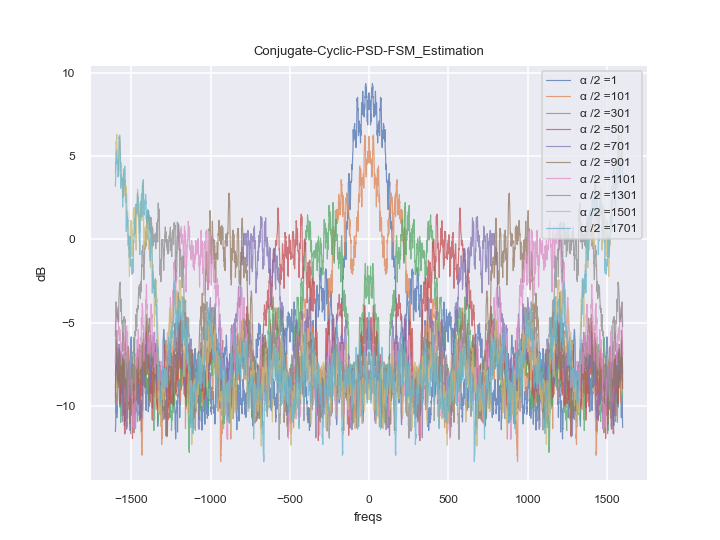

'\n'

In [65]:
# 6. The Frequency Smoothed Conjugate Cyclic Periodogram (c_fscp)
def c_fscp(z_t, alpha_vec, N, Ts, Fs, freqs):
    f = lambda x, h=None: signal.fftconvolve(x, h, "same")
    time_index, h_rect = rectfilter(N, Ts, Fs)
    h_rect = h_rect/np.sum(h_rect)
    df_cp, alpha_vec = c_cp_0(z_t, alpha_vec, freqs)
    fcp = df_cp.transform(f, axis=0, h=h_rect)
    return fcp, alpha_vec

# N controls bias of the alpha paramaters

N   =   10  #repeats_per_symbol             #(int) – Length of the filter in samples.
Ts  =   20    #sym_per_sec       #(float) – Symbol period in seconds.
Fs  =   10      # 1/dt             #(float) – Sampling Rate in Hz.




alpha_vec = 1 + np.linspace(0, 1700//ALPHA, 10).astype(int)*int(ALPHA) 
#alpha_vec =  2 + np.asarray([-1, 0, 1])*int(ALPHA) 

print(alpha_vec)
df_fscp, alpha_vec = c_fscp(x, alpha_vec, N, Ts, Fs, freqs)

cols = df_fscp.columns
ccols = [f"{chr(945)} /2 ={i}" for i in cols]
df_fscp.columns = ccols
# Graph
plt.close("all")
(10*np.log10(np.abs(df_fscp))).plot(linewidth=0.75, alpha=0.75)
plt.title("Conjugate-Cyclic-PSD-FSM_Estimation")
plt.xlabel("freqs")
plt.ylabel("dB")
plt.show()
'''
'''

[   0  100  300  500  700  900 1100 1300 1500 1700]
SCF estimate max peak: 
count      10.000000
mean     -127.200000
std      1035.863976
min     -1586.000000
25%      -714.000000
50%      -100.500000
75%       605.500000
max      1398.000000
dtype: float64 


<IPython.core.display.Javascript object>


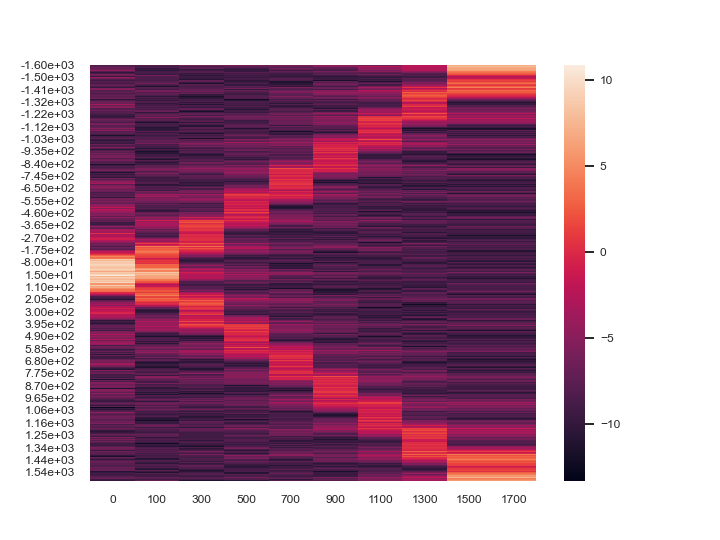

In [62]:
# Test the alpha X freqs plots... 
# SCF .... 


N   =   10  #repeats_per_symbol             #(int) – Length of the filter in samples.
Ts  =   20    #sym_per_sec       #(float) – Symbol period in seconds.
Fs  =   10             #(float) – Sampling Rate in Hz.


alpha_vec = np.linspace(0, 1700//ALPHA, 10).astype(int)*int(ALPHA)
print(alpha_vec)

df_SCF, alpha_vec = fscp(x, alpha_vec, N, Ts, Fs, freqs)


print(f"SCF estimate max peak: \n{ df_SCF.idxmax(axis=0, skipna=True).describe()} ")


# Graph
ix = [f"{i:.2e}" for i in df_SCF.index]
df_SCF.index = ix
plt.close("all")
sns.heatmap(10*np.log10(np.abs(df_SCF)))
plt.show()



C_SCF estimate max peak: 
count      10.000000
mean       22.500000
std      1030.723505
min     -1573.000000
25%      -524.750000
50%       -11.000000
75%       833.250000
max      1573.000000
dtype: float64 


<IPython.core.display.Javascript object>


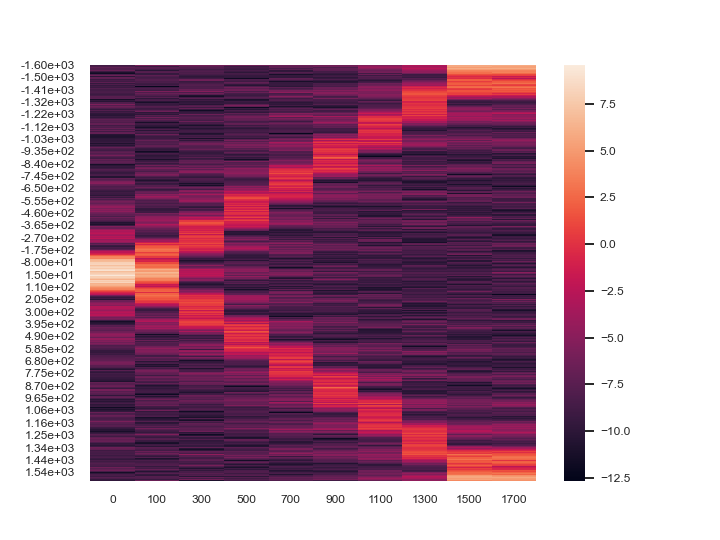

In [63]:
# Test the alpha X freqs plots... 


N   =   10  #repeats_per_symbol             #(int) – Length of the filter in samples.
Ts  =   20    #sym_per_sec       #(float) – Symbol period in seconds.
Fs  =   10      # 1/dt             #(float) – Sampling Rate in Hz.


alpha_vec = np.linspace(0, 1700//ALPHA, 10).astype(int)*int(ALPHA)
df_C_SCF, alpha_vec = c_fscp(x, alpha_vec, N, Ts, Fs, freqs)

print(f"C_SCF estimate max peak: \n{ df_C_SCF.idxmax(axis=0, skipna=True).describe()} ")

# Graph.
sns.set(font_scale=0.7)
ix = [f"{i:.2e}" for i in df_C_SCF.index]
df_C_SCF.index = ix

plt.close("all")
sns.heatmap(10*np.log10(np.abs(df_C_SCF)))
plt.show()
